# Using the Internet Archive for Time-Traveling Research

In [2]:
import pandas as pd 
from helpers import normalize_filename, fetch
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [3]:
import requests
import time

def fetch_snapshots(url, from_date=None, to_date=None, retries=0, delay=5):
    """
    Function to fetch all snapshots from the Internet Archive's Wayback Machine,
    with error handling for timeouts, connection errors, and retries upon empty results.

    Parameters:
    url (str): The URL for which snapshots need to be fetched.
    from_date (str, optional): Start date for fetching snapshots in the format 'yyyy-mm-dd'.
    to_date (str, optional): End date for fetching snapshots in the format 'yyyy-mm-dd'.
    retries (int): The number of times to retry the request if the result is empty.
    delay (int): The number of seconds to wait between retries.

    Returns:
    list: A list of dictionaries, each representing a snapshot.
    """
    # API endpoint for the Wayback Machine
    wayback_api = "http://web.archive.org/cdx/search/cdx?output=json&fl=timestamp,original"

    # Convert user input dates to the Wayback Machine format
    if from_date:
        from_date = from_date.replace("-", "") + "000000"
        wayback_api += f"&from={from_date}"
    if to_date:
        to_date = to_date.replace("-", "") + "235959"
        wayback_api += f"&to={to_date}"

    for i in range(retries + 1):
        try:
            api_url = wayback_api + '&url=' + url

            # Make the request to the API
            response = requests.get(api_url, timeout=10)

            # Check if the request was successful
            if response.status_code == 200:
                # Convert the response text to JSON
                data = response.json()

                # Remove the first element, which is the header
                if len(data) > 0:
                    data = data[1:]

                # If the result is empty, retry after a delay
                if not data and retries > 0:
                    print("Result is empty, retrying...")
                    print(f'API URL: {api_url}')
                    time.sleep(delay)
                    continue

                # Convert each snapshot into a dictionary
                snapshots = [{"timestamp": item[0], "url": item[1]} for item in data]

                return snapshots

            else:
                print(f"Error: HTTP {response.status_code}")
                break

        except requests.exceptions.Timeout:
            print("Request timed out, retrying...")
            time.sleep(delay)
            continue

        except requests.exceptions.ConnectionError:
            print("Connection error, retrying...")
            if retries == 0:
                retries = 1
            time.sleep(delay)
            continue

    print("Failed to fetch snapshots after multiple attempts")
    return []


In [4]:
nyt_snapshots = fetch_snapshots('https://www.nytimes.com', from_date='2020-01-01', to_date='2020-12-31')

In [5]:
nyt_snapshots

[{'timestamp': '20200101000601', 'url': 'https://www.nytimes.com/'},
 {'timestamp': '20200101002915', 'url': 'http://www.nytimes.com/'},
 {'timestamp': '20200101002920', 'url': 'https://www.nytimes.com/'},
 {'timestamp': '20200101005908', 'url': 'https://www.nytimes.com/'},
 {'timestamp': '20200101011106', 'url': 'http://www.nytimes.com/'},
 {'timestamp': '20200101011613', 'url': 'https://www.nytimes.com/'},
 {'timestamp': '20200101011708', 'url': 'https://www.nytimes.com/'},
 {'timestamp': '20200101012159', 'url': 'https://www.nytimes.com/'},
 {'timestamp': '20200101012200', 'url': 'http://nytimes.com/'},
 {'timestamp': '20200101012230', 'url': 'https://www.nytimes.com/'},
 {'timestamp': '20200101022136', 'url': 'http://www.nytimes.com/'},
 {'timestamp': '20200101022137', 'url': 'https://www.nytimes.com/'},
 {'timestamp': '20200101022244', 'url': 'http://nytimes.com/'},
 {'timestamp': '20200101022847', 'url': 'https://www.nytimes.com/'},
 {'timestamp': '20200101022954', 'url': 'http:/

In [6]:
nytdf = pd.DataFrame(nyt_snapshots)
nytdf.head()

,timestamp,url
0,20200101000601,https://www.nytimes.com/
1,20200101002915,http://www.nytimes.com/
2,20200101002920,https://www.nytimes.com/
3,20200101005908,https://www.nytimes.com/
4,20200101011106,http://www.nytimes.com/


In [7]:
nytdf['date'] = pd.to_datetime(nytdf['timestamp']).dt.date
nytdf = nytdf.loc[nytdf.url=='https://www.nytimes.com/',:]
nytdf

,timestamp,url,date
0,20200101000601,https://www.nytimes.com/,2020-01-01
2,20200101002920,https://www.nytimes.com/,2020-01-01
3,20200101005908,https://www.nytimes.com/,2020-01-01
5,20200101011613,https://www.nytimes.com/,2020-01-01
6,20200101011708,https://www.nytimes.com/,2020-01-01
...,...,...,...
79144,20201231214916,https://www.nytimes.com/,2020-12-31
79149,20201231221259,https://www.nytimes.com/,2020-12-31
79151,20201231230028,https://www.nytimes.com/,2020-12-31
79154,20201231230626,https://www.nytimes.com/,2020-12-31


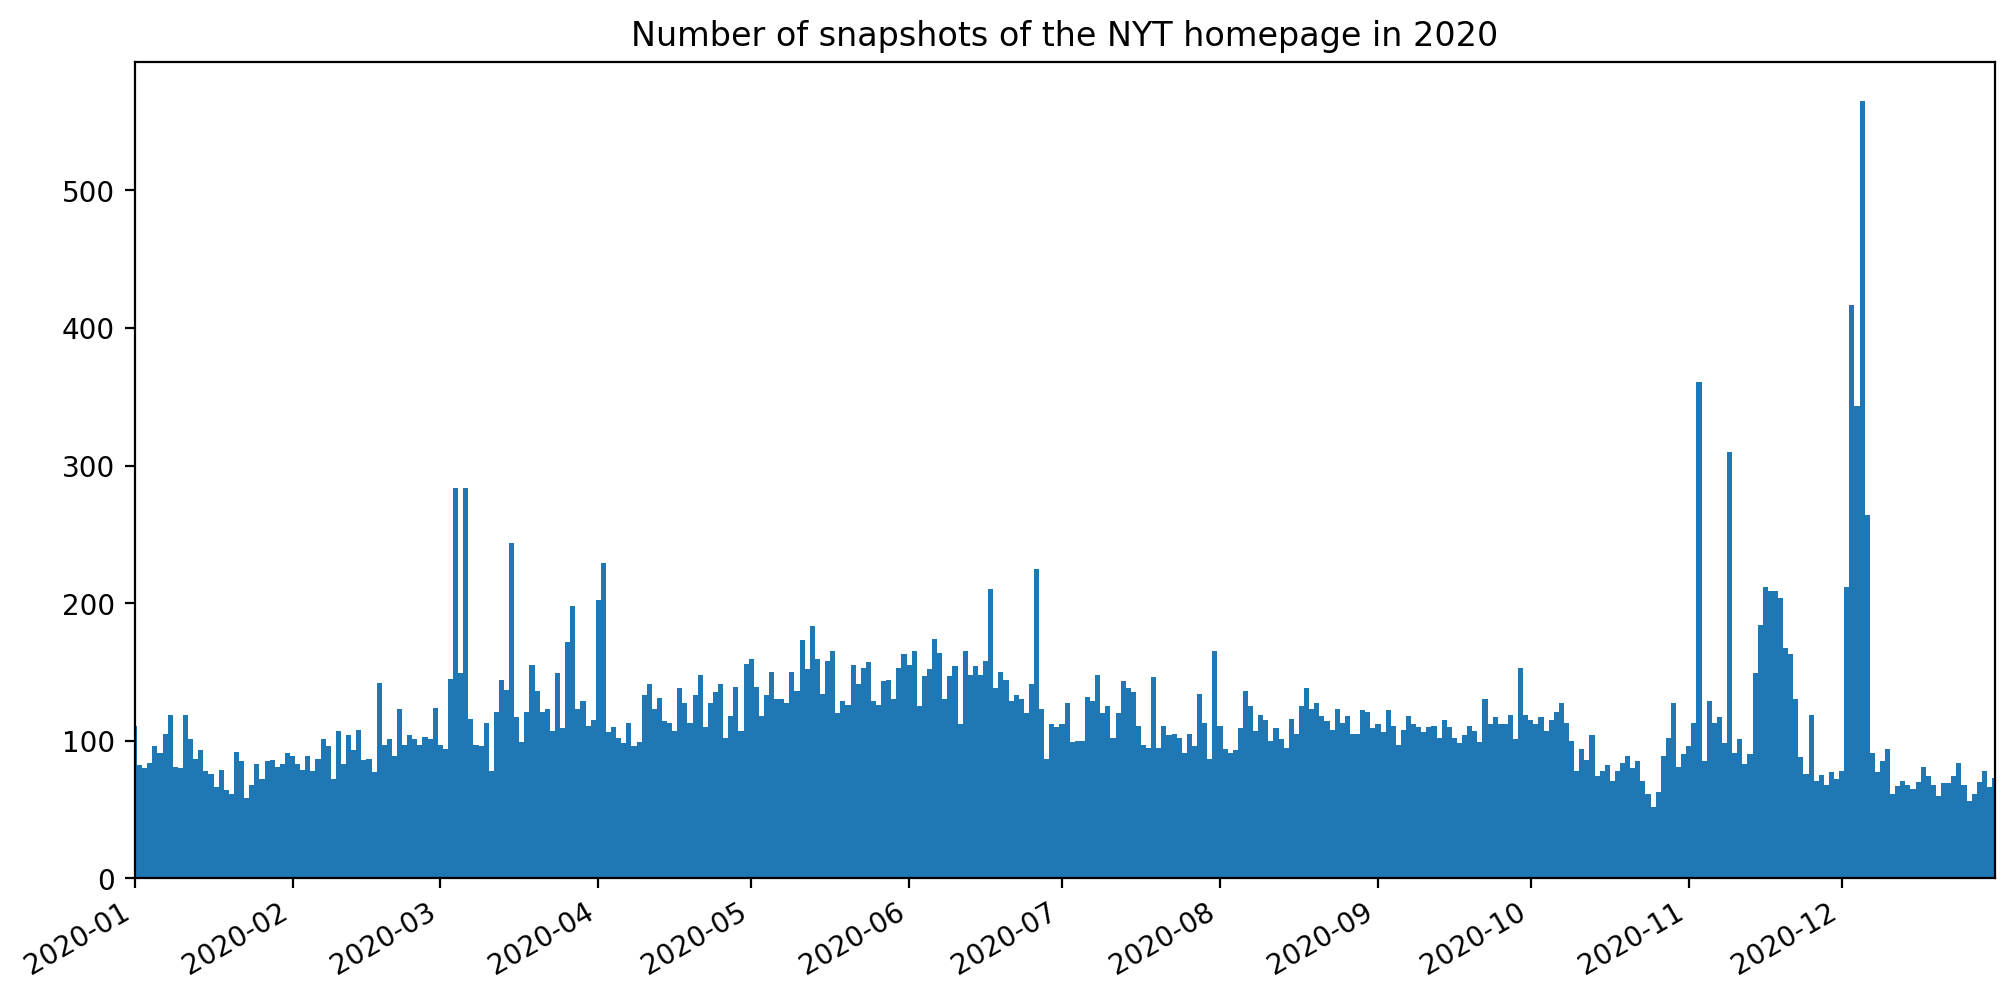

In [8]:
import matplotlib.dates as mdates

# Group by date
data_by_day = nytdf.groupby('date').size()

# Start and end dates for your plot range
start_date = data_by_day.index.min()
end_date = data_by_day.index.max()

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
ax.bar(data_by_day.index, data_by_day.values, width=1)

# Set the title
ax.set_title('Number of snapshots of the NYT homepage in 2020')

# Set major ticks locator to the first day of each month and format for the x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set x-axis limits
ax.set_xlim(start_date, end_date)

# Rotate and align the tick labels
fig.autofmt_xdate()

# Show the plot
plt.show()


In [9]:
def fetch_archived_page(timestamp, url):
    """
    Function to fetch the HTML content of an archived page from the Internet Archive's Wayback Machine.

    Parameters:
    timestamp (str): The timestamp of the snapshot.
    url (str): The original URL of the snapshot.

    Returns:
    str: The HTML content of the archived page.
    """
    # Construct the URL of the archived page
    archived_url = f"http://web.archive.org/web/{timestamp}id_/{url}"

    # Make the request to the API
    html = fetch(archived_url)

    return html

In [10]:
specific_page = nytdf.loc[0,['timestamp','url']].to_dict()
specific_page

{'timestamp': '20200101000601', 'url': 'https://www.nytimes.com/'}

In [11]:
specific_page = nytdf.loc[100,['timestamp','url']].to_dict()
html = fetch_archived_page(**specific_page)

Fetching http://web.archive.org/web/20200101142813id_/https://www.nytimes.com/


In [12]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')

In [13]:
[h2.text for h2 in soup.find_all('h2')]

['Hospitals and Schools Are Being Bombed in Syria. We Took a Closer Look.',
 'Iraq Protests Swarm Near U.S. Embassy Again, Dispersing Amid Tear Gas',
 'Trump Warns Iran as Risk of Wider Armed Conflict Grows',
 'Why did the U.S. become the focus of Iraqis’ anger?',
 'Kim Jong-un Takes a Wait-and-See Approach as Trump Faces a Tough Year',
 'Impeachment Trial Looming, Chief Justice Reflects on Judicial Independence',
 'In a Video Meant to Unite Campus, Almost Everyone Was White',
 'Y2K @ 20',
 'Our Best Recipes of 2019',
 'The Book Review Podcast',
 'The Neediest Cases Fund',
 'No More Phones and Other Tech Predictions for the Next Decade',
 'Sport Should Teach Girls That the Best Person Wins',
 'Protect Veterans From Fraud',
 'The Extremely Online Decade of ‘Get Out,’ Fake Meat and Crystals',
 'Republican Women Are in Crisis',
 'The Year in Charts',
 'How to Protect New York’s Jews',
 'Doctors, Nurses and the Paperwork Crisis That Could Unite Them',
 'A New Year’s Climate Diet',
 'The Le

In [ ]:
soup